In [23]:
%pip install pandas openpyxl torch scikit-learn facenet-pytorch matplotlib torchsampler

Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd

# Assuming the xlsx file is named 'data.xlsx'
df = pd.read_excel('dataset/combined.xlsx', engine='openpyxl')

# Merging the columns B, C, D and E, F, G
right_lip = ['B', 'C', 'D']
left_lip = ['E', 'F', 'G']
lst = []

# loop through the records
for index, row in df.iterrows():
    right_lip_values = row[right_lip].values
    left_lip_values = row[left_lip].values
    
    # get bigger value between right and left lip
    highest_right_idx = row[right_lip].idxmax()
    highest_left_idx = row[left_lip].idxmax() 
    
    right_idx = right_lip.index(highest_right_idx)
    left_idx = left_lip.index(highest_left_idx)
    
    isRightBigger = right_idx if right_idx > left_idx else left_idx
    
    # add the biggest side to lst
    if isRightBigger == right_idx:
        headers = ['A'] + right_lip
    else:
        headers = ['A'] + left_lip

    lst.append(row[headers].values)

df = pd.DataFrame(lst, columns=['A', 'B', 'C', 'D'])

# get sumition of each column
sums = df[right_lip].sum()
highest = sums.idxmax()

# create empty dataframe
df2 = pd.DataFrame()

# loop through each column
for header in right_lip:
    imgs = df[df[header] == 1] # get all rows where the df[header] is 1
    balancing_ratio = sums[highest] / sums[header] # get the balancing ratio
    balanced_rows = imgs.sample(frac=balancing_ratio, replace=True) # sample the rows with replacement
    df2 = pd.concat([df2, balanced_rows]) # add the balanced rows to the new dataframe

# Duplicate the rows
df2 = df2.sample(frac=6, replace=True)

# Extract image names and class labels
image_names = df2['A'].tolist()
class_labels = df2[right_lip].values

print(df2)

                                                      A  B  C  D
1653           Smile-Makeover-before-997894-1819950.JPG  1  0  0
813   All-on-4-Dental-Implants-before-2380323-251706...  1  0  0
499       Porcelain-Veneers-before-11527260-4929640.jpg  1  0  0
645        Porcelain-Veneers-before-2593454-2587235.jpg  0  1  0
312            Dental-Crown-before-12824606-5697637.JPG  1  0  0
...                                                 ... .. .. ..
1416         Smile-Makeover-before-10627177-4674001.png  0  1  0
1137       Porcelain-Veneers-before-1411195-2070134.JPG  1  0  0
1446         Smile-Makeover-before-11982790-5110678.jpg  0  1  0
362        Porcelain-Veneers-before-2370008-2513118.jpg  0  1  0
796       Porcelain-Veneers-before-13301015-6042526.jpg  1  0  0

[15678 rows x 4 columns]


In [7]:
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms

global_tranformer = transforms.Compose([
    transforms.Resize((300, 300), antialias=True),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomCrop((256, 256)),
])

# get iamge edges
def get_edge_triangle_blur(image):
    
    # if pill image convert to cv2 image
    if isinstance(image, Image.Image):
        img = image
    else:
        img = Image.fromarray(image)
    
    # convert to cv2 image in grayscale
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Apply Gaussian blur
    img_blur = cv2.GaussianBlur(img, (3,3), 0)
    
    # Apply Canny edge detection with triangle threshold
    edge_triangle_blur = cv2.Canny(img_blur, 20, 30)
    
    return edge_triangle_blur

def augument_image(img: Image.Image):
    transformed_img = global_tranformer(img)
    cv2_img = get_edge_triangle_blur(transformed_img)
    pil_img = Image.fromarray(cv2_img).convert('RGB')
    return pil_img

def load_image(image_path):
    img = Image.open(image_path)
    transformed_img = transforms.ToTensor()(augument_image(img))
    return transformed_img


In [26]:
import torch.utils
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import torch.utils.data
import torch

class MyData(Dataset):
    def __init__(self, images_names, class_labels):
        self.images_names = images_names
        self.class_labels = class_labels
        
    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, idx):
        image = self.images_names[idx]
        image_path = "/root/ortho-ai/dataset/imgs/" + image
        image = load_image(image_path)
        
        label = self.class_labels[idx]
        
        return image, label
    


# Split data into training and test sets (80% training, 20% test)
images_train, images_test, labels_train, labels_test = train_test_split(image_names, class_labels, test_size=0.2, random_state=42)

# Calculate class weights based on the presence of each class across all columns
class_counts = torch.sum(torch.tensor(class_labels), dim=0)
class_weights = 1. / class_counts.float()

# Create a list of weights for each training sample
weights = torch.sum(class_weights[labels_train], dim=1)

# Create WeightedRandomSampler for imbalanced classes
sampler = WeightedRandomSampler(weights, len(weights))

# Create your dataset
train_dataset = MyData(images_train, labels_train)
full_dataset = MyData(image_names, class_labels)
test_dataset = MyData(images_test, labels_test)

# Create a DataLoader
batch = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch, sampler=sampler)
full_dataloader = DataLoader(full_dataset, batch_size=batch)
test_dataloader = DataLoader(test_dataset, batch_size=batch)

In [27]:
from torchvision.models import resnet50
import torch.nn as nn

class LipLineResNet(nn.Module):
    def __init__(self):
        super(LipLineResNet, self).__init__()
        self.resnet = resnet50(weights='ResNet50_Weights.DEFAULT') # Use pretrained weights
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity() # Remove the final layer
        self.left_fc = nn.Linear(num_ftrs, 3) # Adjusted for ResNet101's output size
        self.right_fc = nn.Linear(num_ftrs, 3)

    def forward(self, x):
        x = self.resnet(x)
        left_output = self.left_fc(x)
        right_output = self.right_fc(x)
        return left_output, right_output

In [28]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.epochs_no_improve = 0

        if self.verbose and self.early_stop:
            print("Early stopping")

In [29]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR

# Define a simple warmup scheduler
def warmup_scheduler(optimizer, warmup_steps):
    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return 1.
    return LambdaLR(optimizer, lr_lambda)

In [30]:
import torch
import torch.optim as optim

# Load the ResNet model
torch.cuda.empty_cache()
model = resnet50(weights='ResNet50_Weights.DEFAULT')
num_classes = 3 # Adjust this to the number of classes in your dataset
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

warmup_steps = 10  # Number of steps for warmup
scheduler_warmup = warmup_scheduler(optimizer, warmup_steps)
scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)


# Training loop
num_epochs = 10
early_stopping = EarlyStopping(patience=7, verbose=True)
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for step, data in enumerate(train_dataloader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(1), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Update the learning rate during warmup
        if epoch * len(train_dataloader) + step < warmup_steps:
            scheduler_warmup.step()

    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(1), labels.float())
            val_loss += loss.item()

    val_loss /= len(test_dataloader)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved best model")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    # Update the learning rate based on the validation loss
    scheduler_plateau.step(val_loss)

print("Finished Training")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Train Loss: 0.5377542733081749, Validation Loss: 0.989530647895774
Saved best model
Epoch 2, Train Loss: 0.2635445883069948, Validation Loss: 0.4487417843572947
Saved best model
Epoch 3, Train Loss: 0.1776600863014785, Validation Loss: 0.3109332615015458
Saved best model
Epoch 4, Train Loss: 0.1242142903371429, Validation Loss: 0.1584064300571169
Saved best model
Epoch 5, Train Loss: 0.11040485456730809, Validation Loss: 0.18311488343288704
Epoch 6, Train Loss: 0.0894346840926731, Validation Loss: 0.27528340732488704
Epoch 7, Train Loss: 0.09105745075942892, Validation Loss: 0.1036995988415212
Saved best model
Epoch 8, Train Loss: 0.0725755448095567, Validation Loss: 0.05184800465287147
Saved best model
Epoch 9, Train Loss: 0.06699545649224797, Validation Loss: 0.09272248730329531
Epoch 10, Train Loss: 0.07007964084008637, Validation Loss: 0.0880803839975911
Finished Training


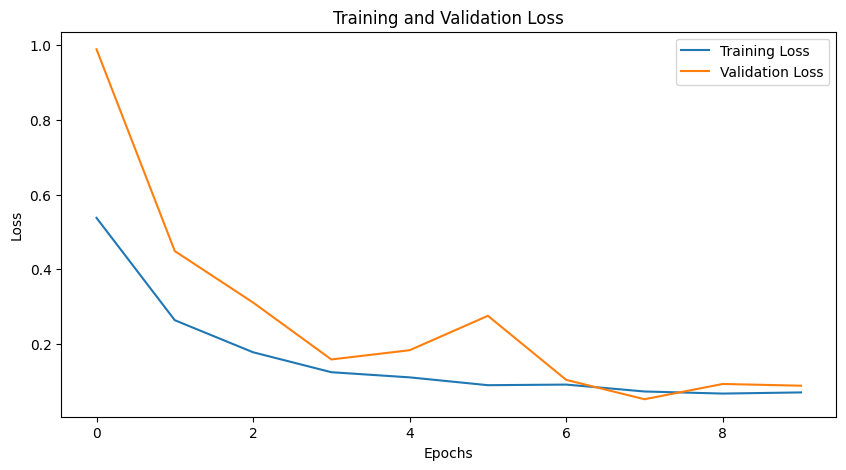

In [31]:
from matplotlib import pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
import torch
# load and save the model
# torch.save(model, 'models/libline_model_v0.10.pth')
model = torch.load('models/libline_model_v0.10.pth')

In [33]:
# Evaluate model accuracy on the test set after training
def evaluate_model(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval() # Set model to evaluation mode

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            # Convert labels to LongTensor (assuming class labels are integers)
            labels = labels.long()

            outputs = model(images)
            # Apply sigmoid to get probabilities
            probabilities = torch.sigmoid(outputs)
            # Convert probabilities to binary predictions
            predicted = (probabilities > 0.5).long()

            total += labels.size(0)
            # Calculate correct predictions for each sample
            correct_sample = (predicted == labels).all(dim=1).sum().item()
            correct += correct_sample

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate_model(model, test_dataloader)

Test Accuracy: 91.84%


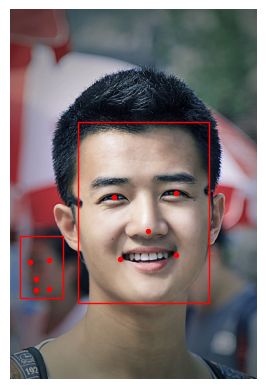

In [18]:
from matplotlib import pyplot as plt
from facenet_pytorch import MTCNN
from PIL import Image

# Load an image from a local file
image_path = 'test_imgs/smile-smiley-face-man-chinese.jpg'
image = Image.open(image_path).convert('RGB')  # Convert image to RGB right after opening

# Initialize MTCNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

# Detect faces and landmarks
boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)

# Visualize the detection (optional)
fig, ax = plt.subplots()
ax.imshow(image)
if boxes is not None:
    for box, landmark in zip(boxes, landmarks):
        ax.scatter(landmark[:, 0], landmark[:, 1], s=8, c='red')
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color='red')
        ax.add_patch(rect)
plt.axis('off')
plt.show()

# Rotate the image based on mouth landmarks to make the mouth horizontal
mouth_landmarks = landmarks[0][3:5]  # Assuming landmarks for the first detected face

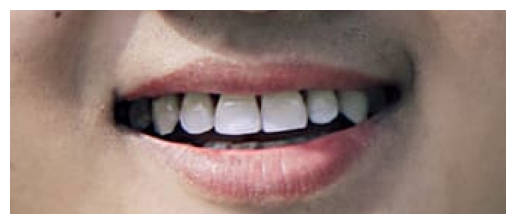

In [19]:
if landmarks is not None:
    margin = 60  # Adjust based on your needs
    mouth_landmarks = landmarks[0][3:5]  # Assuming landmarks for the first detected face
    mouth_box = [
        min(mouth_landmarks[:,0]) - margin,   # Left
        min(mouth_landmarks[:,1]) - margin,   # Top
        max(mouth_landmarks[:,0]) + margin,   # Right
        max(mouth_landmarks[:,1]) + margin    # Bottom
    ]
    mouth_crop = image.crop((mouth_box[0], mouth_box[1], mouth_box[2], mouth_box[3])).convert('RGB')

    # Display the cropped mouth region
    plt.imshow(mouth_crop)
    plt.axis('off')
    plt.show()
    

Probabilities for lipline
Class 1: 0.9793038368225098
Class 2: 0.0196696724742651
Class 3: 0.001026499317958951
Predicted lip line: low


(-0.5, 327.5, 134.5, -0.5)

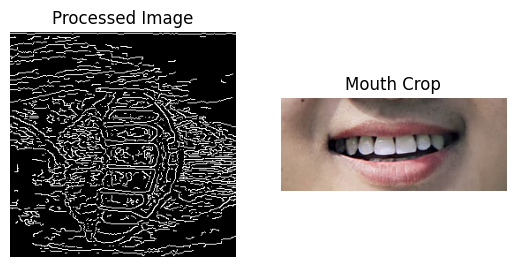

In [20]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Preprocess the image
aug_img = augument_image(mouth_crop)

# image_path = 'WhatsApp Image 2024-04-30 at 20.28.20_5afa815e.jpg'
# image = Image.open(image_path)
# aug_img = augument_image(image)

# Set the model to evaluation mode
model.eval()

# Make a prediction
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
aug_img = transforms.ToTensor()(aug_img)
with torch.no_grad():
    image_tensor = aug_img.unsqueeze(0).to(device)
    outputs = model(image_tensor)


# Convert logits to probabilities using softmax
probabilities = torch.nn.functional.softmax(outputs, dim=1)

# Print the probabilities for all classes
print("Probabilities for lipline")
for i, prob in enumerate(probabilities[0]):
    print(f"Class {i+1}: {prob.item()}")


classes = ["low", "medium", "high"]

# Find the index of the maximum probability
max_prob_index = torch.argmax(probabilities[0]).item()

# Map the index to the class name
lip_line = classes[max_prob_index]
print(f"Predicted lip line: {lip_line}")

# show augmented image and moth crop next to each other
fig, ax = plt.subplots(1, 2)
ax[0].imshow(aug_img.T)
ax[0].set_title('Processed Image')
ax[0].axis('off')
ax[1].imshow(mouth_crop)
ax[1].set_title('Mouth Crop')
ax[1].axis('off')

lab->bgr edges.png minVal : 0.0, maxVal : 0.7095924615859985


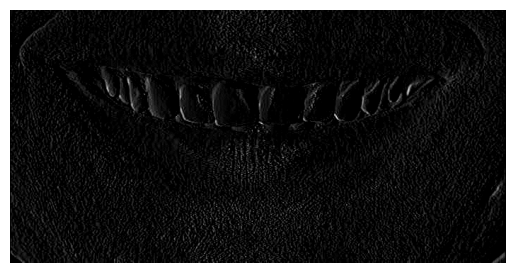

lab edges.png minVal : 0.0, maxVal : 0.7095924615859985


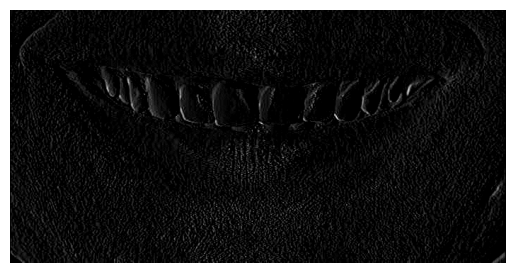

bgr edges.png minVal : -97.18199920654297, maxVal : 74.2280044555664


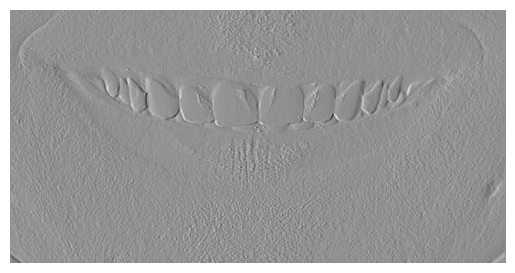

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show(name, img, dolog=0):
    # Convert the image to grayscale if it has more than one channel
    if len(img.shape) > 2:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img

    minVal, maxVal = cv2.minMaxLoc(img_gray)[0:2]
    print(f"{name} minVal : {minVal}, maxVal : {maxVal}")

    if dolog:
        shifted = img_gray + minVal
        tmp = np.log(shifted)
        minVal, maxVal = cv2.minMaxLoc(tmp)[0:2]
        draw = cv2.convertScaleAbs(tmp, alpha=255.0/(maxVal - minVal), beta=-minVal * 255.0/(maxVal - minVal))
    else:
        draw = cv2.convertScaleAbs(img_gray, alpha=255.0/(maxVal - minVal), beta=-minVal * 255.0/(maxVal - minVal))

    plt.imshow(draw, cmap='gray')
    plt.axis('off')
    plt.show()

def main():
    src = cv2.imread("test_imgs/Reverse-smile-arc-pose.png", cv2.IMREAD_COLOR)

    lab = cv2.cvtColor(src, cv2.COLOR_BGR2Lab)

    sobel_lab = cv2.Sobel(lab, cv2.CV_32F, 1, 0, ksize=1)
    sobel_bgr = cv2.Sobel(src, cv2.CV_32F, 1, 0, ksize=1)

    bgr_sobel_lab = cv2.cvtColor(sobel_lab, cv2.COLOR_Lab2BGR)
    show("lab->bgr edges.png", bgr_sobel_lab, 0)
    gray_sobel_lab = cv2.cvtColor(bgr_sobel_lab, cv2.COLOR_BGR2GRAY)

    gray_sobel_bgr = cv2.cvtColor(sobel_bgr, cv2.COLOR_BGR2GRAY)

    show("lab edges.png", gray_sobel_lab, 0)
    show("bgr edges.png", gray_sobel_bgr)

    cv2.waitKey(0)

main()

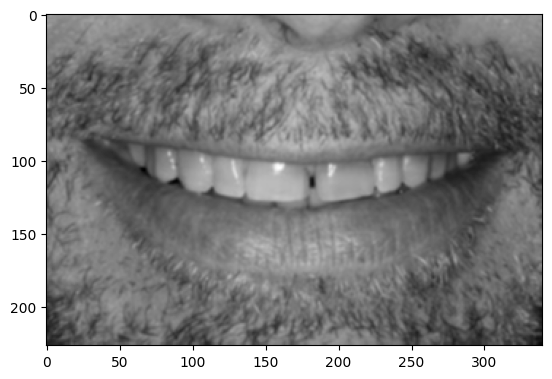

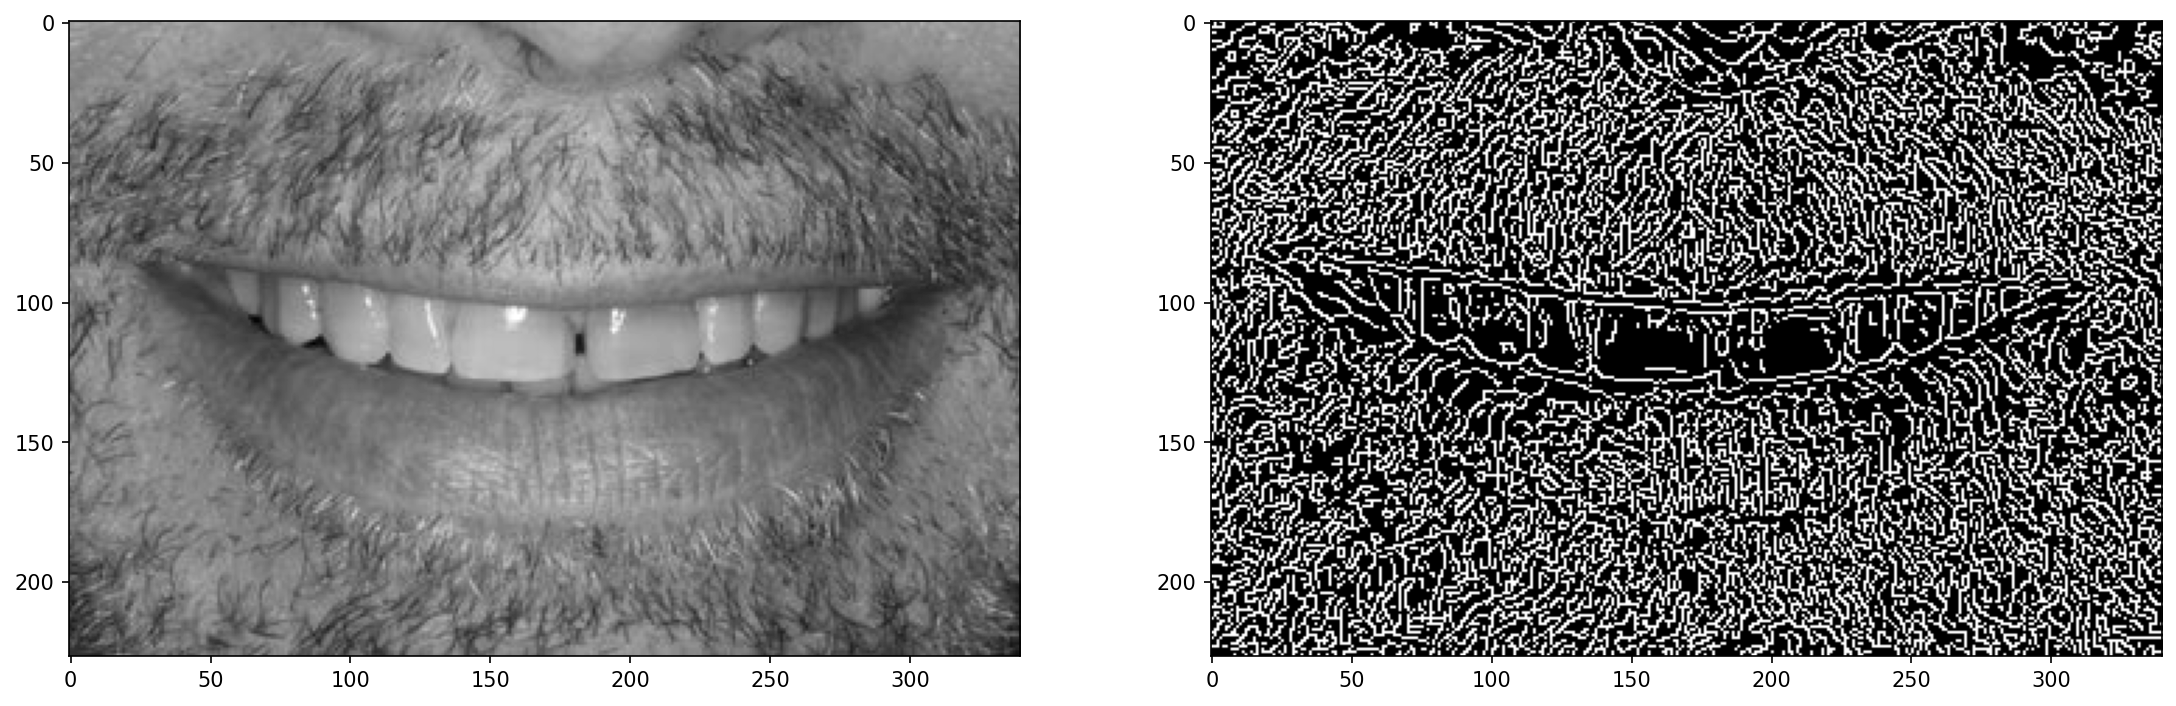

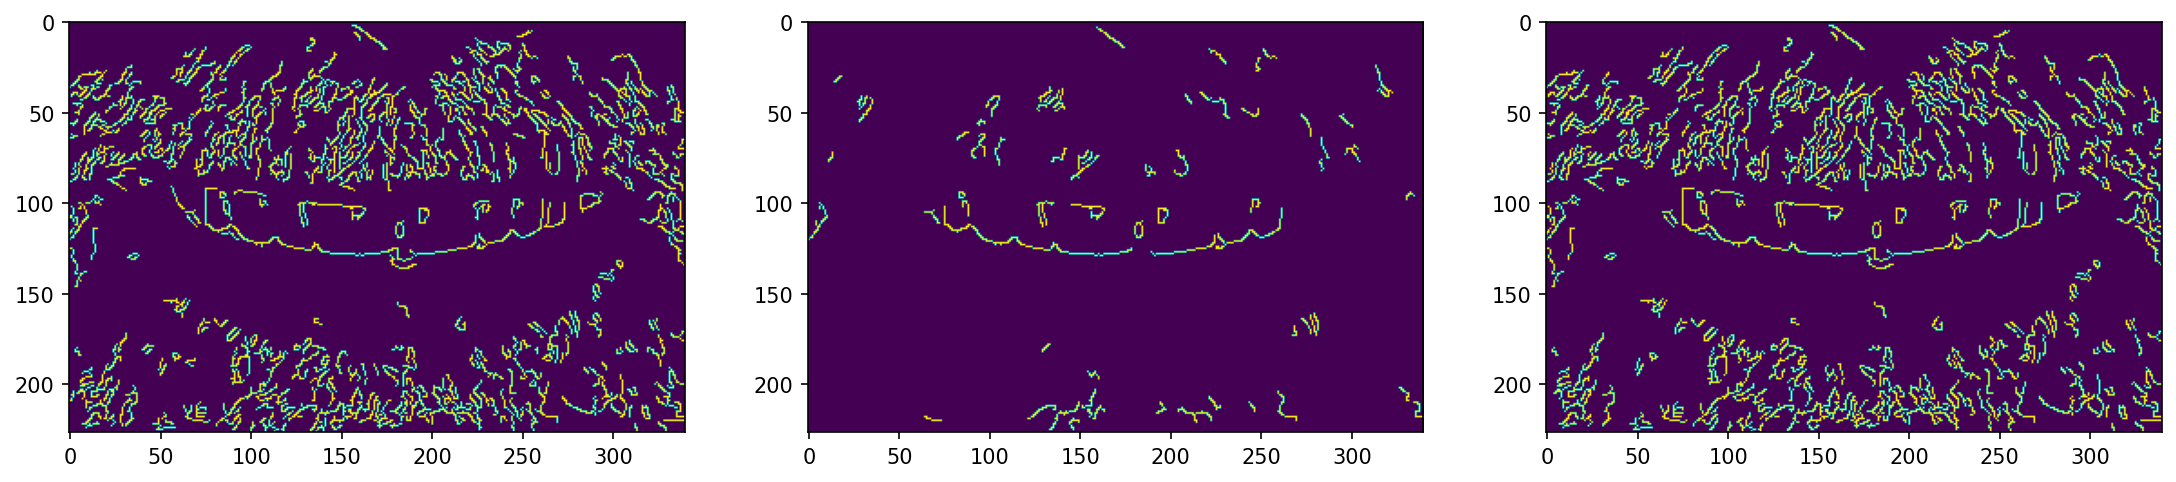

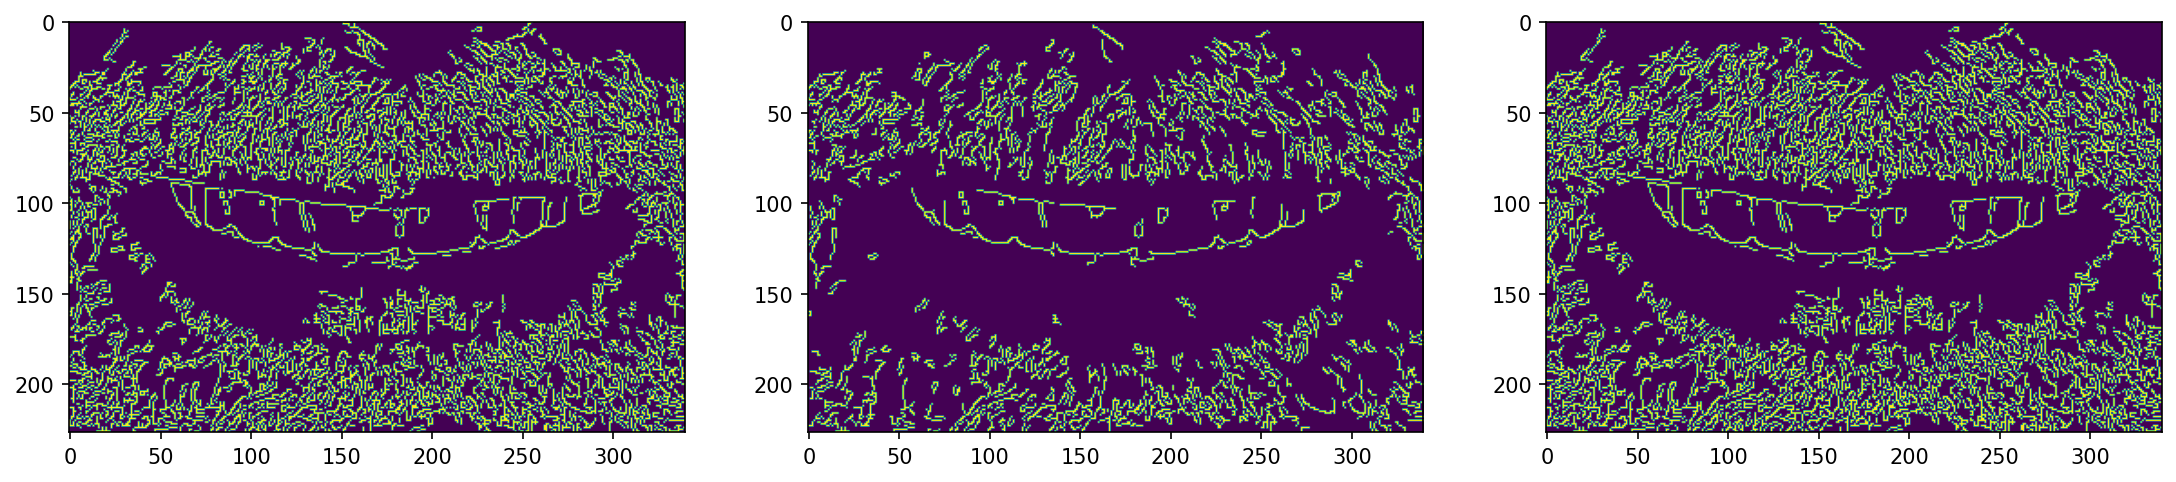

In [38]:
import cv2
import matplotlib.pyplot as plt

image_path = "/root/ortho-ai/dataset/imgs/" + image_names[0]
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img_blur = cv2.GaussianBlur(img, (3,3), 0)

plt.imshow(img_blur, cmap='gray')

# Canny Edge Detection
edge = cv2.Canny(img_blur, 20, 30)

fig, ax = plt.subplots(1, 2, figsize=(18, 6), dpi=150)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(edge, cmap='gray')


otsu_thresh, _ = cv2.threshold(img_blur, 0, 255, cv2.THRESH_OTSU)
triangle_thresh, _ = cv2.threshold(img_blur, 0, 255, cv2.THRESH_TRIANGLE)
manual_thresh = np.median(img_blur)

def get_range(threshold, sigma=0.33):
    return (1-sigma) * threshold, (1+sigma) * threshold

otsu_thresh = get_range(otsu_thresh)
triangle_thresh = get_range(triangle_thresh)
manual_thresh = get_range(manual_thresh)


edge_otsu_blur = cv2.Canny(img_blur, *otsu_thresh)
edge_triangle_blur = cv2.Canny(img_blur, *triangle_thresh)
edge_manual_blur = cv2.Canny(img_blur, *manual_thresh)

fig, ax = plt.subplots(1, 3, figsize=(18, 6), dpi=150)
ax[0].imshow(edge_otsu_blur)
ax[1].imshow(edge_triangle_blur)
ax[2].imshow(edge_manual_blur)

edge_otsu = cv2.Canny(img, *otsu_thresh)
edge_triangle = cv2.Canny(img, *triangle_thresh)
edge_manual = cv2.Canny(img, *manual_thresh)

fig, ax = plt.subplots(1, 3, figsize=(18, 6), dpi=150)
ax[0].imshow(edge_otsu)
ax[1].imshow(edge_triangle)
ax[2].imshow(edge_manual)